In [ ]:
import numpy as np
import pandas as pd
import random
import torch
from matplotlib import pyplot as plt
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import plotly
import plotly.graph_objs as go

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


In [ ]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_random_seed(42)

In [ ]:
import collections

In [ ]:
!pip install apimoex

In [ ]:
import requests
import apimoex

session = requests.Session()

In [ ]:
df = pd.DataFrame(apimoex.get_board_history(session, 'MOEX')).dropna()
df = df[-5000:]
df = df.reset_index(drop=True)
print(df.head())

  BOARDID   TRADEDATE  CLOSE  VOLUME       VALUE
0    TQBR  2013-04-04  48.13  210880  10148463.2
1    TQBR  2013-04-05  47.69  345780  16698661.4
2    TQBR  2013-04-08  47.54  227840  10889442.1
3    TQBR  2013-04-09  47.48  425000  20233800.0
4    TQBR  2013-04-10  46.96  140100   6624780.0


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    y = df['CLOSE'][:],
    line =  dict(shape =  'spline' ),
    name = 'Курс акции MOEX'
            ))
fig.show()

In [ ]:
class Environment:
    '''
        Рабочая среда робота, внутри которого будет
        происходить дальнейшее обучение
    '''
    def __init__(self, train_data, test_data, normalize = True, noise = True):
        self.train_length = train_data.shape[0]
        self.test_length = test_data.shape[0]
        self.data = np.concatenate([train_data.flatten(), test_data.flatten()])


        if noise:
            # add a noise
            self.data += np.random.normal(0, 0.05, size = self.data.shape)*self.data
        if normalize:
            # minmax normalization
            self.data = (self.data - self.data.min()) / (self.data.max() - self.data.min())

    def get_state(self, time, lookback, diff = True):
        """
        We return the derivatives of a separate window in our selection
        and remove the zeros at the beginning
        """
        window = self.data[time-lookback:time]
        if diff: window = np.diff(window, prepend = window.flatten()[0])
        return window

    def get_reward(self, action, action_time, reward_time, coef = 1, fee=0.001):
        """
        0 => long   1 => short
        """
        if action == -1:
            action = -1
        elif action == 1:
            action = 1

        # We pull out the current price
        price_now = self.data[action_time]
        # We pull out the next price
        price_reward = self.data[reward_time]
        # We get the difference
        price_diff = (price_reward - price_now)
        # We add the following number to the portfolio:
        # Delta of currency change * buy/sell/hold * purchase ratio  fee -- broker fee
        reward = price_diff * action * coef*(1-fee)

        return reward

We don't want to study trading, we need to develop intuition to predict the price. Thus, a small simple NN is needed.

In [ ]:
# define the nn architecture
class Net(nn.Module):
    """Строим простую модель нейронки"""
    def __init__(self, state_shape, action_shape, init_form="normal"):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(state_shape, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, action_shape)

        self.init_form = init_form
        if self.init_form is not None:
            self.init()

    def forward(self, x):
        x = self.fc2(F.relu(self.fc1(x)))
        x = self.fc3(F.relu(x))
        return F.tanh(x)

              # xavier weight initialization
    def init(self):
        sigmoid_gain = torch.nn.init.calculate_gain("relu")
        for child in self.children():
            if isinstance(child, nn.Linear):
                if self.init_form == "normal":
                    torch.nn.init.xavier_normal_(child.weight,
                                                 gain=sigmoid_gain)
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                elif self.init_form == "uniform":
                    torch.nn.init.xavier_uniform_(child.weight,
                                                  gain=sigmoid_gain)
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                else:
                    raise NotImplementedError()

In [ ]:
class BuyHoldSellAgent:
    '''
        Агент для покупки продажи
    '''
    def __init__(self, state_shape = 10, action_shape = 2, experience_size = 100):
        self.state_shape = state_shape
        self.action_shape = action_shape
        self.experience_size = experience_size
        self.experience = collections.deque(maxlen=self.experience_size)

        # Creating an instance of the model
        self.model = Net(state_shape, action_shape)

        # Let's create an error function
        self.criterion = nn.SmoothL1Loss()
        # Let's add an optimizer
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=2e-4)

    def save_experience(self, current_state, action, reward, next_state):
        """A method for saving previous experimental data"""
        self.experience.append({
            'state_i': current_state,
            'action_i': action,
            'reward_i': reward,
            'state_i_1': next_state
        })

    def replay_experience(self, gamma, sample_size):
        """A method for optimizing training data"""
        # Creating a fixed selection from the added events
        indices_sampled = np.random.choice(
            len(self.experience),
            sample_size,
            replace=False
        )
        # We are going through only those elements that were added to the selection

        current_states = []
        actions = []
        rewards = []
        next_states = []
        for i in indices_sampled:
            state_i, action_i, reward_i, state_i_1 = self.experience[i]['state_i'], self.experience[i]['action_i'], self.experience[i]['reward_i'], self.experience[i]['state_i_1']
            current_states.append(state_i)
            actions.append(action_i)
            rewards.append(reward_i)
            next_states.append(state_i_1)

        current_states = np.array(current_states).squeeze()
        next_states = np.array(next_states).squeeze()

        # We get a forecast for the following state
        next_q_values = self.model(torch.from_numpy(next_states).float()).detach().numpy()

        # we get a forecast for the current state
        current_q_values = self.model(torch.from_numpy(current_states).float()).detach().numpy()
        # The Bellman equation
        for i in range(len(indices_sampled)):
            # we enter it in the Q table for training
            current_q_values[i, actions[i]] = rewards[i] + gamma * next_q_values[i, :].max()

        outputs = self.model(torch.from_numpy(np.expand_dims(current_states.reshape(-1, WINDOW_SHAPE), 0)).float())[0]
        loss = self.criterion(outputs, torch.Tensor(current_q_values))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def get_value_action_value(self, state):
        """Метод для прогноза сигнала"""
        state = np.expand_dims(state, axis = 0)
        pred = self.model(torch.from_numpy(state).float())
        return pred.flatten()

In [ ]:
# number of epochs
epochs = 200
# The significance of the reward is one step ahead
gamma = 0.99
# initial epsilon
epsilon = 1.0
# epsilon_decay
alpha_e = 0.97

In [ ]:
# dataset size
DATASET_LENGTH = len(df['CLOSE'])
# The size of the window from which the previous data will be taken
WINDOW_SHAPE = 10
# Previous data step
REWARD_TIME = 1
# number of action
ACTIONS_SHAPE = 2
# Sample size
SAMPLE_SIZE = 32
EXP_SIZE = 128
# test size
SIZE_test = 50


In [ ]:
action_to_backtest_action = {
    1: 1,  # buy
    0: -1,  # sell
}

In [ ]:
train_dataset = np.array(df['CLOSE'][:-SIZE_test])
test_dataset = np.array(df['CLOSE'][-SIZE_test:])

In [ ]:
# We prescribe a new environment and transmit data on the closing price
environment = Environment(train_dataset, test_dataset, normalize = False, noise = False)
agent = BuyHoldSellAgent(WINDOW_SHAPE, ACTIONS_SHAPE, EXP_SIZE)

In [ ]:
set_random_seed(42)


for i in range(epochs):

    learning_progress = []
    for j in range(WINDOW_SHAPE, environment.train_length - REWARD_TIME, REWARD_TIME):
        print(f"{i} / {epochs} : {j} {DATASET_LENGTH - REWARD_TIME}", end='\r')

        # 1. Get the current state. Derivatives in a separate interval
        # The current Y on the graph and the previous WINDOW_SHAPE steps
        state_j = environment.get_state(j, WINDOW_SHAPE)
        # We get a prediction for this state through the model
        q_value_j = agent.get_value_action_value(state_j)

        # 2. Select an action for the current state
        # Depending on the length of the epsilon, we choose a random action
        # or real ones according to predictions
        if (np.random.random() < epsilon):
            action = np.random.randint(0, ACTIONS_SHAPE)
        else:
            action = np.argmax(q_value_j.detach().numpy())

        # 3. We receive a reward for the selected action
        reward_value_j = environment.get_reward(action, j, j + REWARD_TIME)
        learning_progress.append(reward_value_j)

        # 4. We get the future state. Derivatives in the future interval
        # The current Y + 1 on the graph and the previous WINDOW_SHAPE steps
        state_j_1 = environment.get_state(j + 1, WINDOW_SHAPE)

        # 5. We save all the received data of the agent
        agent.save_experience(state_j, action, reward_value_j, state_j_1)

        # 6. As soon as the number of previously received samples has exceeded
        # for what is necessary, we begin to train the network
        if j > 5*SAMPLE_SIZE:
            agent.replay_experience(gamma, SAMPLE_SIZE)

    # With each step, we decrease the epsilon so that the bot begins to act
    # according to his own forecasts, he stopped studying the environment
    epsilon *= alpha_e

    print('Epoch', i, '...', np.mean(learning_progress))
    learning_progress = []

Epoch 0 ... 0.0063241043478261035
Epoch 1 ... 0.014774775652173975
Epoch 2 ... 0.035342013913043396
Epoch 3 ... 0.011376438260869442
Epoch 4 ... 0.007456883478260843
Epoch 5 ... 0.036339276521739086
Epoch 6 ... 0.00367284521739129
Epoch 7 ... 0.022801523478260956
Epoch 8 ... 0.06999254608695661
Epoch 9 ... 0.020372650434782664
Epoch 10 ... 0.044550187826087
Epoch 11 ... 0.0228049982608695
Epoch 12 ... -0.0029883130434782547
Epoch 13 ... 0.021606198260869597
Epoch 14 ... 0.01505623304347824
Epoch 15 ... 0.0020640208695651427
Epoch 16 ... 0.009347165217391255
Epoch 17 ... 0.010521641739130384
Epoch 18 ... 0.03514047652173921
Epoch 19 ... 0.008888493913043612
Epoch 20 ... 0.012095718260869604
Epoch 21 ... 0.06070097739130443
Epoch 22 ... 0.01921554782608683
Epoch 23 ... 0.036693704347826095
Epoch 24 ... 0.0390878295652173
Epoch 25 ... 0.034250932173913035
Epoch 26 ... 0.06096506086956525
Epoch 27 ... 0.08122651826086962
Epoch 28 ... 0.05917554782608702
Epoch 29 ... 0.06937750956521734
Epo

In [ ]:
actions = []

for j in range(WINDOW_SHAPE, len(df['CLOSE']), REWARD_TIME):
    # 1. We obtain derivatives in a separate interval
    # Current price and previous WINDOW_SHAPE steps
    state_j = environment.get_state(j, WINDOW_SHAPE)

    # We get the prediction of the bot according to the data
    q_value_j = agent.get_value_action_value(state_j)
    # We define the signal and record it in events
    actions.append(action_to_backtest_action[np.argmax(q_value_j.detach().numpy())])

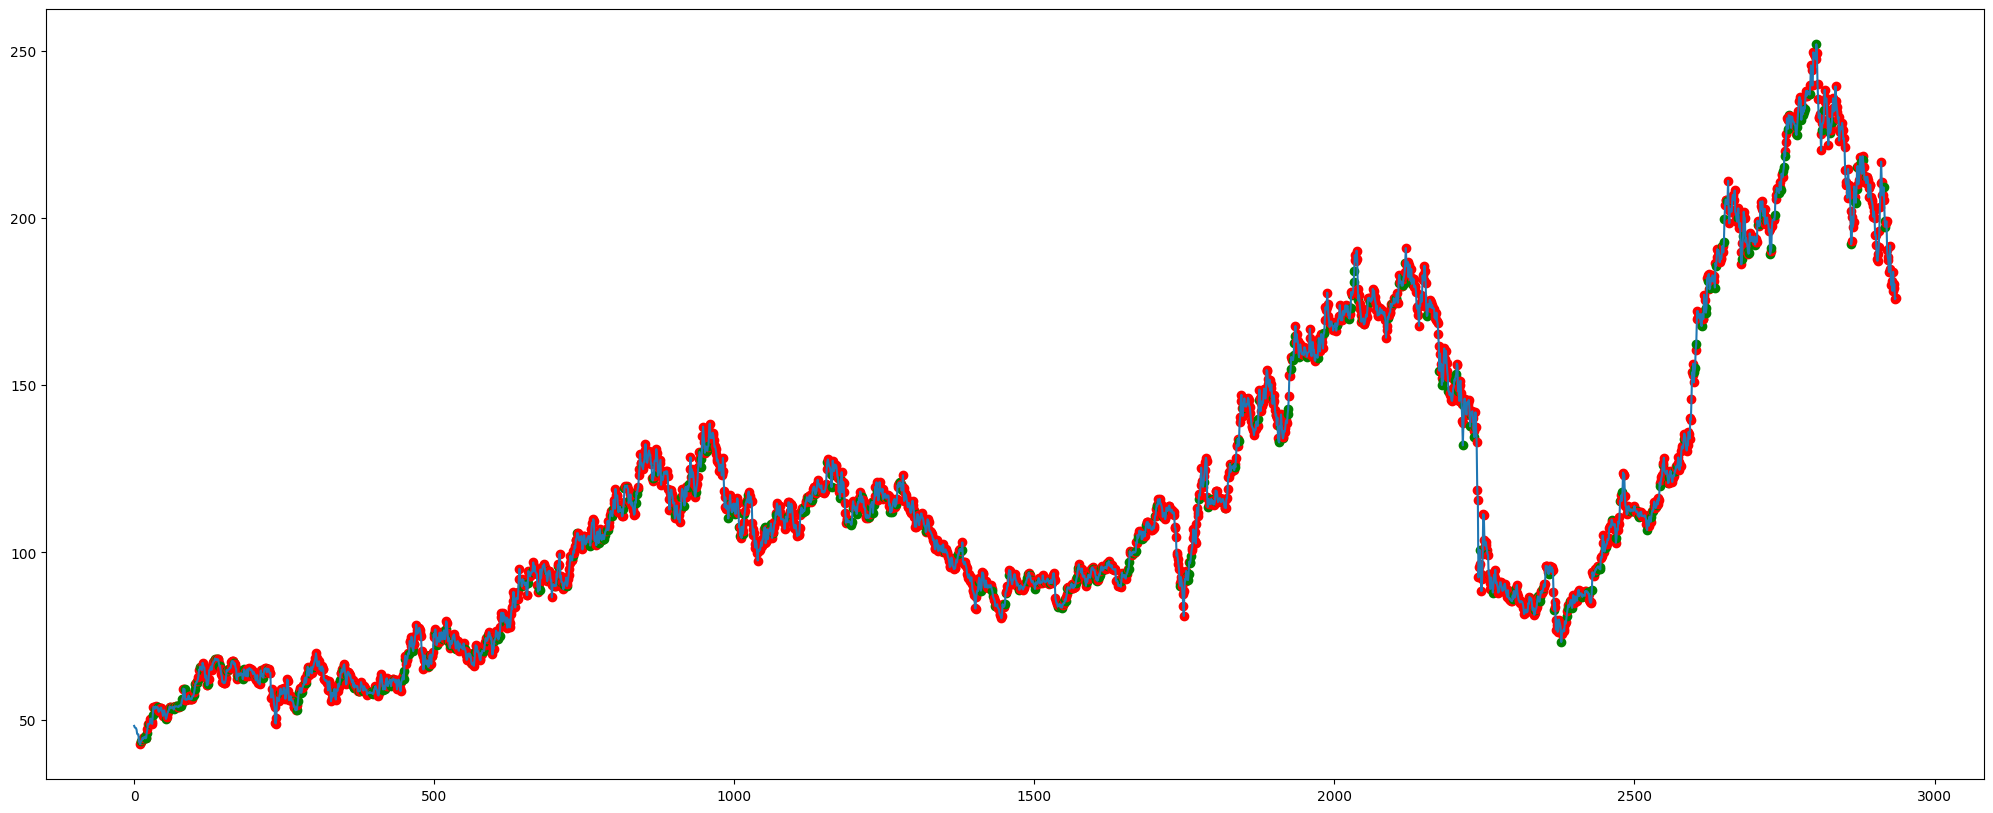

In [ ]:
plt.figure(figsize = (25, 10))
dataf = environment.data[::REWARD_TIME]
plt.plot(dataf)
for e, a in enumerate(actions):
    print(f"{e} {a}", end='\r')
    e += WINDOW_SHAPE//REWARD_TIME
    if a == 1:
        plt.scatter(e, dataf[e], color = 'green')
    elif a == -1:
        plt.scatter(e, dataf[e], color = 'red')

plt.show()

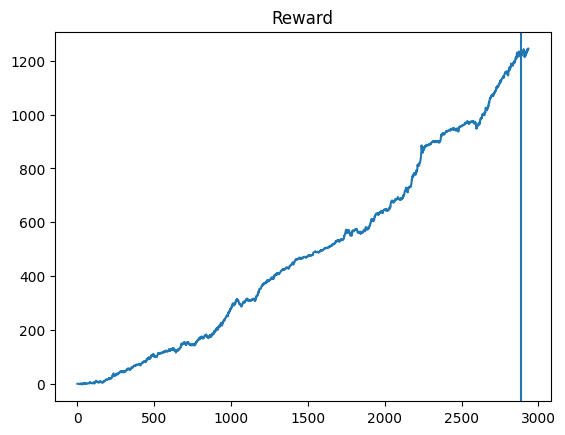

In [ ]:
 # We make a schedule of income. Let's make a frame of the Price format/The signal
backtest = pd.DataFrame({
    'price': dataf.flatten(),
    'signal': [0] * (WINDOW_SHAPE//REWARD_TIME) + actions
})
# We get price derivatives and make a shift
backtest['price_diff'] = backtest['price'].diff().shift(-1)
# We summarize the income and display a graph
(backtest['price_diff'] * backtest['signal']).cumsum().plot()
plt.title('Reward')

plt.axvline(x=(dataf.shape[0]-SIZE_test)//REWARD_TIME)
plt.show()

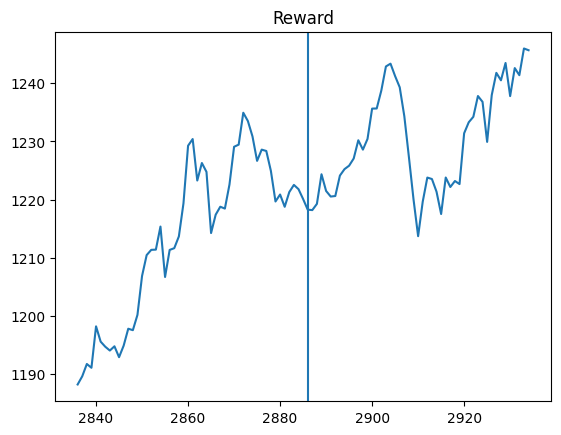

In [ ]:
 # We make a schedule of income. Let's make a frame of the Price format/The signal
backtest = pd.DataFrame({
    'price': dataf.flatten(),
    'signal': [0] * (WINDOW_SHAPE//REWARD_TIME) + actions
})
# We get price derivatives and make a shift
backtest['price_diff'] = backtest['price'].diff().shift(-1)
# We summarize the income and display a graph
(backtest['price_diff'] * backtest['signal']).cumsum()[-100:].plot()
plt.title('Reward')

plt.axvline(x=(dataf.shape[0]-SIZE_test)//REWARD_TIME)
plt.show()